In May 2017, Taeksoo Kim & al. published a way to learn discover domain relation with Generative Adversial Networks: 
https://arxiv.org/pdf/1703.05192.pdf . Let's try to implement this nice paper and get nice results.

## 1. DiscoGAN Architecture ##

The initial idea is to used a standard GAN architecture to transform picture from one domain to another. 

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "./gan1.png",width=500, height=250)

Unfortunately the equality GBA ◦ GAB(xA) = xA should be satisfied, but this hard constraint is difficult to optimize. For this reason, we minimize the distance d(GBA ◦ GAB(xA),xA), where any form of metric function (L1, L2, Huber loss) can be used. For this reason, we minimize the distance d(GBA ◦ GAB(xA),xA), where any form of metric function (L1, L2, Huber loss) can be used.

In [2]:
Image(url= "./gan2.png",width=500, height=250)

As the application must be bijective between domain A to domain B, we also need tov minimized(GAB ◦GBA(xB),xB):

In [3]:
Image(url= "./gan3.png",width=500, height=250)

This is the model exposed in the paper. We hence have 2 generators ($G_{AB}$ and $G_{BA}$), and two discriminators $D_A$ and $D_B$.

## 2. Implementation ##


Let's build the generators. COmpared to standard GAN, the generators here take a picture as input instead of random Gaussian noise z. Each generator is composed of an encoder and a decoder. The official paper implementation mentions 4 conv2 layer followed by 4 ConvTranspose2d layers, use leakyrelu for the encoder part et Relu for decoder part.

In [4]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.backend import resize_images
from keras.initializers import RandomNormal

from keras.optimizers import Adam,RMSprop

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
def generator():
    weight_init = RandomNormal(mean=0.0, stddev=0.02) # as suggested in DCGAN paper
    # Image input
    input_pic = (128, 128,3)
    
    model = Sequential()

    # Decoder ######
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding='same',input_shape=input_pic,kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha=0.2))  
    
    model.add(Conv2D(filters=64*2, kernel_size=(4,4), strides=(2,2), padding='same',input_shape=input_pic,kernel_initializer=weight_init))
    model.add(BatchNormalization(momentum=0.9)) 
    model.add(LeakyReLU(alpha=0.2)) 
    
    model.add(Conv2D(filters=64*4, kernel_size=(4,4), strides=(2,2), padding='same',input_shape=input_pic,kernel_initializer=weight_init))
    model.add(BatchNormalization(momentum=0.9)) 
    model.add(LeakyReLU(alpha=0.2)) 
    
    model.add(Conv2D(filters=64*8, kernel_size=(4,4), strides=(2,2), padding='same',input_shape=input_pic,kernel_initializer=weight_init))
    model.add(BatchNormalization(momentum=0.9)) 
    model.add(LeakyReLU(alpha=0.2)) 
    
    """model.add(model.add(Conv2D(filters=100, kernel_size=(4,4), strides=(1,1), padding='same',input_shape=input_pic,kernel_initializer=weight_init)))
    model.add(BatchNormalization(momentum=0.9)) 
    model.add(LeakyReLU(alpha=0.2))""" 
    
    # Encoder ######
    """model.add(Conv2DTranspose(filters=64*8, kernel_size=(4, 4), strides=(1,1), padding='same',kernel_initializer=weight_init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))"""
    
    model.add(Conv2DTranspose(filters=64*4, kernel_size=(4, 4), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    
    model.add(Conv2DTranspose(filters=64*2, kernel_size=(4, 4), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    
    model.add(Conv2DTranspose(filters=64, kernel_size=(4, 4), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('sigmoid'))
    
    model.add(Conv2DTranspose(filters=3, kernel_size=(4, 4), strides=(2,2), padding='same',kernel_initializer=weight_init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('sigmoid'))
    
    return model

a = generator()
print(a.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       524544    
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 256)       1024      
__________

Let's write the discriminator. 

In [10]:
def discriminator():
    weight_init = RandomNormal(mean=0.0, stddev=0.02) # as suggested in paper
    in_shape = (128, 128,3)
    model = Sequential()
    
    model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2,2), padding='same',input_shape=in_shape,kernel_initializer=weight_init))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(filters=64*2, kernel_size=(4, 4), strides=(2,2), padding='same',input_shape=in_shape,kernel_initializer=weight_init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(filters=64*4, kernel_size=(4, 4), strides=(2,2), padding='same',input_shape=in_shape,kernel_initializer=weight_init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(filters=64*8, kernel_size=(4, 4), strides=(2,2), padding='same',input_shape=in_shape,kernel_initializer=weight_init))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(filters=1, kernel_size=(4, 4), strides=(1,1), padding='same',input_shape=in_shape,kernel_initializer=weight_init))

    return model

b = discriminator()
print(b.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 256)       524544    
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 16, 256)       1024      
__________

## 3. Train ##
### 3.1 Single iteration ###

Let's train the model on only one batch, just to make things clear. We are going to use the edge to shoes dataset for now.

In [ ]:
Image(url= "./605_AB.jpg",width=500, height=250)

Picture inside shoes dataset are 512x256 with both edge and full picture. We need first to dissociate this picture in two pictures of size 128x128.

[]

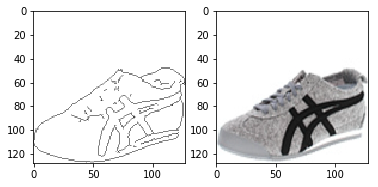

In [14]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def read_picture(filename,img_out_size= 128):
    image = cv2.imread(filename)
    if image is None:
        assert("error reading picture")
    
    imageA = image[:, :256, :]
    imageB = image[:, 256:, :]

    imageA = cv2.resize(imageA, (img_out_size,img_out_size))
    imageB = cv2.resize(imageB, (img_out_size,img_out_size))
    
    return imageA,imageB

X,Y = read_picture('605_AB.jpg')

plt.subplot(1, 2, 1)
plt.imshow(X)
plt.subplot(1, 2, 2)
plt.imshow(Y)

plt.plot()
    
    
    
    


We also need to normalize the picture:

In [16]:
def normalize_picture(img):
    # The data is currently in a range [0, 255].
    # Transform data to have a range [0, 1].
    img = img / 255.
    return img

X = normalize_picture(X)
Y = normalize_picture(Y)

Ok, we have two picture, on from domain A, and one from domain B. We need a function that will create the batch:

In [106]:
import os,fnmatch


image_paths = "./edges2shoes/train"
data = fnmatch.filter(os.listdir(image_paths), '*.jpg')

def batch_creation(batch_size,batch_idx):
    # get 64 pictures from the files
    process_batchA = []
    process_batchB = []
    current_pic = data[batch_idx*batch_size:batch_idx*batch_size+batch_size]
    
    #print(current_pic)
    # call read picture
    for i in range(len(current_pic)):
        filename = os.path.join(image_paths, current_pic[i])
        A,B = read_picture(filename)
        # normalize picture
        A = normalize_picture(A)
        B = normalize_picture(B)
        #append 2 pic in a list
        process_batchA.append(A)
        process_batchB.append(B)
    
    return process_batchA, process_batchB
        
    
batch_size = 128    
batchA, batchB = batch_creation(batch_size,0)
batchA = np.asarray(batchA)
batchB = np.asarray(batchB)
print(batchA.shape)
print(len(data))

(128, 128, 128, 3)
49825


We should have two batches of 64 pictures for domain A and domain B.

Let's create and compile dicriminators and generators:

In [76]:
disc_optimizer = Adam(lr=0.0002, beta_1=0.5)

discriA = discriminator()
discriB = discriminator()
discriA.compile(loss='mse',optimizer=disc_optimizer,metrics=['accuracy'])
discriB.compile(loss='mse',optimizer=disc_optimizer,metrics=['accuracy'])

Create combined model for generator:

In [ ]:
gen_AB = generator()
gen_BA = generator()



# Input images(real)
img_A = Input((128,128,3))
img_B = Input((128,128,3))

# Translate images to the other domain
fake_B = gen_AB(img_A)
fake_A = gen_BA(img_B)

# back to original domain
back_A = gen_BA(fake_B)
back_B = gen_AB(fake_A)

# For the combined model we will only train the generators
discriA.trainable = False
discriB.trainable = False

# Discriminators determines validity of translated images
valid_A = discriA(fake_A)
valid_B = discriB(fake_B)

combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        fake_B, fake_A,
                                        back_A, back_B ])
combined.compile(loss=['mse', 'mse',
                            'mae', 'mae',
                            'mae', 'mae'],
                      optimizer=disc_optimizer)

combined.summary()


Train the discriminators first :

In [78]:
# Adversarial loss ground truths
patch = int(128 / 2**4)
d_patch = (patch, patch, 1)

valid = np.ones((batch_size,) + d_patch)
fake = np.zeros((batch_size,) + d_patch)


generated_B = gen_AB.predict(batchA) #used to train Db
generated_A = gen_BA.predict(batchB) #used to train Da

# Train the discriminators (real classified as ones and generated as zeros)
dlossA_real = discriA.train_on_batch(batchA, valid)
dlossA_fake = discriA.train_on_batch(generated_A, fake)
dA_loss = 0.5 * np.add(dlossA_real, dlossA_fake)

dlossB_real = discriA.train_on_batch(batchB, valid)
dlossB_fake = discriA.train_on_batch(generated_B, fake)
dB_loss = 0.5 * np.add(dlossB_real, dlossB_fake)

# Total disciminator loss
d_loss = 0.5 * np.add(dA_loss, dB_loss)



/usr/local/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Then train the discriminators:

In [79]:
g_loss = combined.train_on_batch([batchA, batchB], [valid, valid,batchB, batchA,batchA, batchB]) 

Done, we just train the whole model on one batch of picture A and one batcof picture B. Let's add some loops to wrap up eveything

### 3.2 full train ###

Create first the routine to save generated images:

In [114]:
def save_images(epoch, batch):
    r, c = 2, 3
    
    batchA, batchB = batch_creation(1,batch_idx)

    batchA = np.asarray(batchA)
    batchB = np.asarray(batchB)
    
    # Translate images to the other domain
    fake_B = gen_AB.predict(batchA)
    fake_A = gen_BA.predict(batchB)
    
    # Translate back to original domain
    back_A = gen_BA.predict(fake_B)
    back_B = gen_AB.predict(fake_A)

    gen_imgs = np.concatenate([batchA, fake_B, back_A, batchB, fake_A, back_B])
    
    # Rescale images
    #gen_imgs = gen_imgs * 255
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i, j].set_title(titles[j])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("generated_shoes/%d_%d.png" % (epoch, batch_idx))
    plt.close()
    
    


In [113]:
batch_size = 128   
epoch_size = 20
num_examples = len(data)
num_batches = int(num_examples / float(batch_size)) # around 389 batches


for epoch in range(epoch_size):
    for batch_idx in range(num_batches):
        batchA, batchB = batch_creation(batch_size,batch_idx)
        batchA = np.asarray(batchA)
        batchB = np.asarray(batchB)
        
        # Train the discriminators (real classified as ones and generated as zeros)
        dlossA_real = discriA.train_on_batch(batchA, valid)
        dlossA_fake = discriA.train_on_batch(generated_A, fake)
        dA_loss = 0.5 * np.add(dlossA_real, dlossA_fake)

        dlossB_real = discriA.train_on_batch(batchB, valid)
        dlossB_fake = discriA.train_on_batch(generated_B, fake)
        dB_loss = 0.5 * np.add(dlossB_real, dlossB_fake)

        # Total disciminator loss
        d_loss = 0.5 * np.add(dA_loss, dB_loss)
        
        
        g_loss = combined.train_on_batch([batchA, batchB], [valid, valid,batchB, batchA,batchA, batchB]) 

        print ("[%d] [%d/%d], [d_loss: %f, g_loss: %f]" % (epoch, batch_idx,
                                                                        num_batches,
                                                                        d_loss[0], g_loss[0]))

        # If at save interval => save generated image samples
        if batch_idx % 30 == 0:
            save_images(epoch, batch_idx)

        


/usr/local/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[0] [0/389], [d_loss: 3.182958, g_loss: 6.602124]


NameError: name 'save_images' is not defined